In [8]:
import numpy as np
import matplotlib.pyplot as plt
from Network_bayesian import Place_net, Grid_net, Coupled_Net
import brainpy as bp
import brainpy.math as bm
from matplotlib.animation import FuncAnimation
import time
# from scipy.stats import ttest_ind, norm
# from Decoding_method import GOP_decoding, Net_decoding

# 圆周距离函数
def circ_dis(phi_1, phi_2):
    dis = phi_1 - phi_2
    dis = np.where(dis > np.pi, dis - 2 * np.pi, dis)
    dis = np.where(dis < -np.pi, dis + 2 * np.pi, dis)
    return dis

# 默认参数
# grid spacing
lambda_1 = 3
lambda_2 = 4
lambda_3 = 5
Lambda = np.array([lambda_1, lambda_2, lambda_3])
L = lambda_1 * lambda_2 * lambda_3
# cell number
num_p = int(200)
rho_p = num_p / L
rho_g = rho_p
num_g = int(rho_g * 2 * np.pi)  # 为了让两个网络的rho相等
M = len(Lambda)
# feature space
x = np.linspace(0, L, num_p, endpoint=False)
theta = np.linspace(0, 2 * np.pi, num_g, endpoint=False)
# connection range
a_p = 0.3
a_g = a_p / Lambda * 2 * np.pi
# connection strength
J_p = 20
J_g = J_p
J_pg = J_p / 25


# divisive normalization
k_p = 20.
k_g = Lambda / 2 / np.pi * k_p
# time constants
tau_p = 1
tau_g = 2 * np.pi * tau_p / Lambda
# input_strength
alpha_p = 0.05
alpha_g = 0.05

noise_ratio = 0.007

P_CANN = Place_net(z_min=0, z_max=L, num=num_p, a_p=a_p, k=k_p, tau=tau_p, J0=J_p)
# Grid cells
G_CANNs = bm.NodeList()
for i in range(M):
    G_CANNs.append(Grid_net(z_min=0, z_max=L, num=num_g, num_hpc=num_p, L=Lambda[i], a_g=a_g[i], k_mec=k_g[i], tau=tau_g[i], J0=J_g, W0=J_pg))

Coupled_model = Coupled_Net(HPC_model=P_CANN, MEC_model_list=G_CANNs, num_module=M)


In [9]:

def GOP_decoding(z_t, phi_t, Ip, Ig, alpha_p_infer, alpha_g_infer, Ag, Ap, Rp, total_itenoise_rations=5000):
    sigma_g = np.sqrt(np.sqrt(np.pi) * Ag ** 3 * rho_g * tau_g / (a_g * alpha_g_infer))
    sigma_phi = np.sqrt(8 * np.pi * Ag * tau_g / (Lambda * J_pg * rho_p * Rp))
    sigma_p = np.sqrt(np.sqrt(np.pi) * Ap ** 3 * rho_p * tau_p / (a_p * alpha_p_infer))
    sigma_g_infer = sigma_g * noise_ratio
    sigma_phi_infer = sigma_phi * noise_ratio
    sigma_p_infer = sigma_p * noise_ratio
    eta = 20. * 1e-6
    z_ts = []
    phi_ts = []
    z_ts.append(z_t)
    phi_ts.append(phi_t)
    z_encode_space = np.linspace(0, L, num_p, endpoint=False)

    for itenoise_ration in range(total_itenoise_rations):
        fg_prime = np.zeros((M, num_g))
        for i in range(M):
            dis_theta = circ_dis(theta, phi_t[i])
            fg_prime[i, :] = dis_theta / (2 * a_g[i] ** 2) * np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))

        dis_z = z_encode_space - z_t
        fp_prime = dis_z / (2 * a_p ** 2) * np.exp(-dis_z ** 2 / (4 * a_p ** 2))
        
        Ig_fgprime_prod = Ig * fg_prime
        Ig_fgprime_prod = np.sum(Ig_fgprime_prod, axis=1)
        dphi_fr = Ig_fgprime_prod / sigma_g_infer ** 2

        Ip_fp_prime_prod = Ip * fp_prime
        Ip_fp_prime_prod = np.sum(Ip_fp_prime_prod)
        dr_fr = Ip_fp_prime_prod / sigma_p_infer ** 2

        phi_z = np.mod(z_t / Lambda, 1) * 2 * np.pi
        dis_phi = circ_dis(phi_z, phi_t)
        dphi_tr = 1 / sigma_phi_infer ** 2 * dis_phi
        dr_tr = np.sum(-2 * np.pi / (Lambda * sigma_phi_infer ** 2) * dis_phi)

        dphi = dphi_fr + dphi_tr
        phi_t = phi_t + eta * dphi
        
        phi_t = np.mod(phi_t, 2 * np.pi)
        
        dr = dr_fr + dr_tr
        z_t = z_t + eta * dr

        z_ts.append(z_t)
        phi_ts.append(phi_t)
    return np.array(z_ts), np.array(phi_ts)

def Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05, Coupled_model=Coupled_model):
    Coupled_model.reset_state()
    def initial_net(Ip, Ig): 
        Coupled_model.initial(alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)

    def run_net(i, Ip, Ig): 
        Coupled_model.step_run(i, alpha_p=1, alpha_g=1, Ip=Ip, Ig=Ig)
        phi_decode = Coupled_model.phase
        z_decode = Coupled_model.HPC_model.center
        rp = Coupled_model.HPC_model.r
        up = Coupled_model.HPC_model.u
        rg = bm.zeros([M, num_g])
        ug = bm.zeros([M, num_g])
        for mi in range(M):
            rg[mi, :] = Coupled_model.MEC_model_list[mi].r
            ug[mi, :] = Coupled_model.MEC_model_list[mi].u
        return z_decode, phi_decode, rp, up, rg, ug

    T_init = 500
    z0 = z_truth
    phi_0 = phi_truth
    fg = np.zeros((M, num_g))
    for i in range(M):
        dis_theta = circ_dis(theta, phi_0[i])
        fg[i, :] = np.exp(-dis_theta ** 2 / (4 * a_g[i] ** 2))
    dis_x = x - z0
    fp = np.exp(-dis_x ** 2 / (4 * a_p ** 2))
    I_place = 1 * np.repeat(fp[np.newaxis, :], T_init, axis=0)
    I_grid = 1 * np.repeat(fg[np.newaxis, :, :], T_init, axis=0)
    I_place[int(T_init / 3):, :] = 0
    I_grid[int(T_init / 3):, :, :] = 0

    bm.for_loop(initial_net, (I_place, I_grid), progress_bar=False)
    T = 5000
    indices = np.arange(T)
    I_place = alpha_p * np.repeat(Ip[np.newaxis, :], T, axis=0)
    I_grid = alpha_g * np.repeat(Ig[np.newaxis, :, :], T, axis=0)
    z_record, phi_record, rp, up, rg, ug = bm.for_loop(run_net, (indices, I_place, I_grid), progress_bar=False)

    return z_record, phi_record, up, rp, ug, rg


start_time = time.time()  # 记录开始时间
n_stre = 10
trial_num = 200
noise_stre = np.linspace(0.05, 0.2, n_stre)
std_integrate_net = np.zeros(n_stre)
std_motion_net = np.zeros(n_stre)
std_visual_net = np.zeros(n_stre)
std_integrate_gop = np.zeros(n_stre)
std_bayes = np.zeros(n_stre)

z_truth = 30
phi_truth = np.mod(z_truth / Lambda, 1) * 2 * np.pi 

for noise_n in range(n_stre):
    # 主程序
    neural_noise_sigma = noise_stre[noise_n]
    sigma_phi = np.array([31.7,23.8,19])*neural_noise_sigma/25
    
    z_decode_gop = np.zeros(trial_num)
    z_decode_net = np.zeros(trial_num)
    z_decode_net_motion = np.zeros(trial_num)
    z_decode_net_visual = np.zeros(trial_num)

    for i in range(trial_num):
        z_e = z_truth
        psi = phi_truth + sigma_phi * np.random.randn(M)
        Ig = np.zeros((M, num_g))
        for j in range(M):
            dis_theta = circ_dis(theta, psi[j])
            Ig[j, :] = np.exp(-dis_theta ** 2 / (4 * a_g[j] ** 2)) + neural_noise_sigma * np.random.randn(num_g)
        dis_x = x - z_e
        Ip = np.exp(-dis_x ** 2 / (4 * a_p ** 2)) + neural_noise_sigma * np.random.randn(num_p) 
        z_decode_int, _, up, rp, ug, rg = Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.05)

        max_up = np.max(up, axis=1)
        max_rp = np.max(rp, axis=1)
        Ap = np.max(max_up[-1])
        Rp = np.max(max_rp[-1])
        Ag = np.zeros(M,)
        Rg = np.zeros(M,)
        for mi in range(M):
            max_ug = np.max(ug[:, mi, :], axis=1)
            max_rg = np.max(rg[:, mi, :], axis=1)
            Ag[mi] = np.max(max_ug[-1])
            Rg[mi] = np.max(max_rg[-1])
        z_decode_g, _ = GOP_decoding(z_t=z_truth, phi_t=phi_truth, Ip=Ip, Ig=Ig, alpha_p_infer=0.05, alpha_g_infer=0.05, Ap=Ap, Rp=Rp, Ag=Ag)
        z_decode_mot, _, _, _, _, _ = Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0., alpha_g=0.05)
        z_decode_vis, _, _, _, _, _ = Net_decoding(z_truth, phi_truth, Ip, Ig, alpha_p=0.05, alpha_g=0.)

        z_decode_gop[i] = z_decode_g[-1]
        z_decode_net[i] = z_decode_int[-1].item()
        z_decode_net_motion[i] = z_decode_mot[-1].item()
        z_decode_net_visual[i] = z_decode_vis[-1].item()
        
        if i % 25 == 0:
            print(f"Noise {noise_n + 1}/{n_stre}, Progress: {i/trial_num*100:.2f}%")
    
    error_int_net = z_decode_net-z_truth
    error_mot_net = z_decode_net_motion-z_truth
    error_vis_net = z_decode_net_visual-z_truth
    error_int_gop = z_decode_gop-z_truth
    # mean_integrate_net[noise_n] = np.mean(error_int_net)
    # mean_motion_net[noise_n] = np.mean(error_mot_net)
    # mean_visual_net[noise_n] = np.mean(error_vis_net)
    # mean_integrate_gop[noise_n] = np.mean(error_int_gop)

    std_integrate_net[noise_n] = np.std(error_int_net)
    sigma_1 = np.std(error_mot_net)
    sigma_2 = np.std(error_vis_net)
    std_motion_net[noise_n] = sigma_1
    std_visual_net[noise_n] = sigma_2
    std_integrate_gop[noise_n] = np.std(error_int_gop)
    sigma_3 = np.sqrt(1/(1/sigma_1**2 + 1/sigma_2**2))
    std_bayes[noise_n] = sigma_3
    

end_time = time.time()  # 记录结束时间
print(f"Total runtime: {end_time - start_time:.2f} seconds")

# 保存数据为npz文件
np.savez('results.npz', 
         std_integrate_net=std_integrate_net,
         std_motion_net=std_motion_net,
         std_visual_net=std_visual_net,
         std_integrate_gop=std_integrate_gop,
         std_bayes = std_bayes)


Noise 1/10, Progress: 0.00%
Noise 1/10, Progress: 12.50%
Noise 1/10, Progress: 25.00%
Noise 1/10, Progress: 37.50%
Noise 1/10, Progress: 50.00%
Noise 1/10, Progress: 62.50%
Noise 1/10, Progress: 75.00%
Noise 1/10, Progress: 87.50%
Noise 2/10, Progress: 0.00%
Noise 2/10, Progress: 12.50%
Noise 2/10, Progress: 25.00%
Noise 2/10, Progress: 37.50%
Noise 2/10, Progress: 50.00%
Noise 2/10, Progress: 62.50%
Noise 2/10, Progress: 75.00%
Noise 2/10, Progress: 87.50%
Noise 3/10, Progress: 0.00%
Noise 3/10, Progress: 12.50%
Noise 3/10, Progress: 25.00%
Noise 3/10, Progress: 37.50%
Noise 3/10, Progress: 50.00%
Noise 3/10, Progress: 62.50%
Noise 3/10, Progress: 75.00%
Noise 3/10, Progress: 87.50%
Noise 4/10, Progress: 0.00%
Noise 4/10, Progress: 12.50%
Noise 4/10, Progress: 25.00%
Noise 4/10, Progress: 37.50%
Noise 4/10, Progress: 50.00%
Noise 4/10, Progress: 62.50%
Noise 4/10, Progress: 75.00%
Noise 4/10, Progress: 87.50%
Noise 5/10, Progress: 0.00%
Noise 5/10, Progress: 12.50%
Noise 5/10, Progres

2024-09-17 02:21:19.970014: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m45.348469s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-17 03:29:19.645771: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m44.276231s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-17 03:46:04.772585: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m45.242564s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-17

Noise 7/10, Progress: 0.00%


2024-09-17 04:38:02.433518: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m44.425983s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-17 04:54:48.275421: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m44.185562s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-17 06:13:05.658430: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m45.681826s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Noise 7/10, Progress: 12.50%
Noise 7/10, Progress: 25.00%


2024-09-17 07:30:43.187415: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m49.088878s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-17 07:36:17.749321: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m48.110014s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-09-17 08:14:05.069805: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 36m58.71869s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Noise 7/10, Progress: 37.50%
Noise 7/10, Progress: 50.00%
Noise 7/10, Progress: 62.50%
Noise 7/10, Progress: 75.00%
Noise 7/10, Progress: 87.50%
Noise 8/10, Progress: 0.00%
Noise 8/10, Progress: 12.50%
Noise 8/10, Progress: 25.00%
Noise 8/10, Progress: 37.50%
Noise 8/10, Progress: 50.00%
Noise 8/10, Progress: 62.50%
Noise 8/10, Progress: 75.00%
Noise 8/10, Progress: 87.50%
Noise 9/10, Progress: 0.00%
Noise 9/10, Progress: 12.50%
Noise 9/10, Progress: 25.00%
Noise 9/10, Progress: 37.50%
Noise 9/10, Progress: 50.00%
Noise 9/10, Progress: 62.50%
Noise 9/10, Progress: 75.00%
Noise 9/10, Progress: 87.50%
Noise 10/10, Progress: 0.00%
Noise 10/10, Progress: 12.50%
Noise 10/10, Progress: 25.00%
Noise 10/10, Progress: 37.50%
Noise 10/10, Progress: 50.00%
Noise 10/10, Progress: 62.50%
Noise 10/10, Progress: 75.00%
Noise 10/10, Progress: 87.50%
Total runtime: 38524.99 seconds


In [1]:

# 保存数据为npz文件
np.savez('results.npz', 
         std_integrate_net=std_integrate_net,
         std_motion_net=std_motion_net,
         std_visual_net=std_visual_net,
         std_integrate_gop=std_integrate_gop,
         std_bayes = std_bayes)

plt.figure()

# plt.errorbar(noise_stre, mean_motion_net, yerr=std_motion_net, fmt='-o',label='only motion')
# plt.errorbar(noise_stre, mean_visual_net, yerr=std_visual_net, fmt='-o',label='only visual')
# plt.errorbar(noise_stre, mean_integrate_net, yerr=std_integrate_net, fmt='-o',label='net integration')
# plt.errorbar(noise_stre, mean_integrate_gop, yerr=std_integrate_gop, fmt='-o',label='Bayeian integration')
plt.plot(noise_stre,std_motion_net,label='Mot.',color=[0.,0.5,1],linewidth=3)
plt.plot(noise_stre,std_visual_net,label='Env.',color=[1,0,0.1],linewidth=3)
plt.plot(noise_stre,std_integrate_net,label='Both',color=[0,0.5,0.5],linewidth=3)
plt.plot(noise_stre,std_bayes,label='Bayes',color=[0.2,0.8,1],linewidth=3)
plt.xlabel('Noise level')
plt.ylabel('Decoding error')
plt.legend()


# plt.errorbar(noise_stre, mean_motion_net, yerr=std_motion_net, fmt='-o')
# plt.errorbar(noise_stre, mean_visual_net, yerr=std_visual_net, fmt='-o')
# plt.errorbar(noise_stre, mean_integrate_net, yerr=std_integrate_net, fmt='-o')
# plt.errorbar(noise_stre, mean_integrate_gop-30, yerr=std_integrate_gop, fmt='-o')

plt.tight_layout()
plt.savefig('standard_deviation.png')

# plt.show()

NameError: name 'plt' is not defined

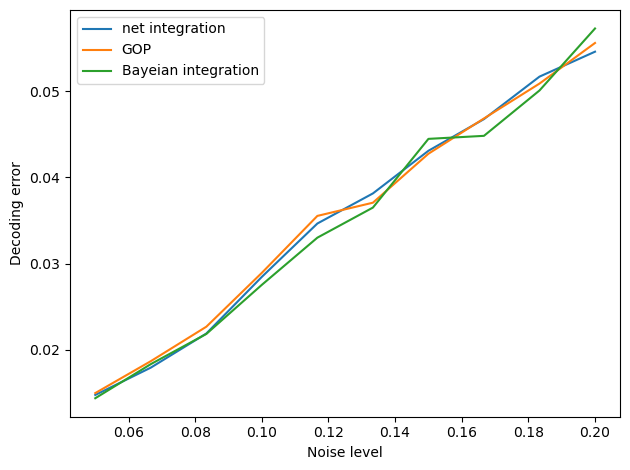

In [11]:

plt.figure()
plt.plot(noise_stre,std_integrate_net,label='net integration')
plt.plot(noise_stre,std_integrate_gop,label='GOP')
plt.plot(noise_stre,std_bayes,label='Bayeian integration')
plt.xlabel('Noise level')
plt.ylabel('Decoding error')
plt.legend()


# plt.errorbar(noise_stre, mean_motion_net, yerr=std_motion_net, fmt='-o')
# plt.errorbar(noise_stre, mean_visual_net, yerr=std_visual_net, fmt='-o')
# plt.errorbar(noise_stre, mean_integrate_net, yerr=std_integrate_net, fmt='-o')
# plt.errorbar(noise_stre, mean_integrate_gop-30, yerr=std_integrate_gop, fmt='-o')

plt.tight_layout()
plt.savefig('compare.png')